<a href="https://colab.research.google.com/github/austinlasseter/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/214_responses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression
- do train/validate/test split
- begin with baselines for classification
- express and explain the intuition and interpretation of Logistic Regression
- use sklearn.linear_model.LogisticRegression to fit and interpret Logistic Regression models

Logistic regression is the baseline for classification models, as well as a handy way to predict probabilities (since those too live in the unit interval). While relatively simple, it is also the foundation for more sophisticated classification techniques such as neural networks (many of which can effectively be thought of as networks of logistic models).

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries:
- category_encoders
- numpy
- pandas
- scikit-learn

In [92]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Do train/validate/test split

## Overview

### Predict Titanic survival 🚢

Kaggle is a platform for machine learning competitions. [Kaggle has used the Titanic dataset](https://www.kaggle.com/c/titanic/data) for their most popular "getting started" competition. 

Kaggle splits the data into train and test sets for participants. Let's load both:

In [93]:
# note that we have 2 different datasets - train and test.
import pandas as pd
train = pd.read_csv(DATA_PATH+'titanic/train.csv')
test = pd.read_csv(DATA_PATH+'titanic/test.csv')

Notice that the train set has one more column than the test set:

In [94]:
# train has 12, but test has only 11.
train.shape, test.shape

((891, 12), (418, 11))

Which column is in train but not test? The target!

In [95]:
# the target is whether or not people survived the voyage.
set(train.columns) - set(test.columns)

{'Survived'}

### Why doesn't Kaggle give you the target for the test set?

#### Rachel Thomas, [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)

> One great thing about Kaggle competitions is that they force you to think about validation sets more rigorously (in order to do well). For those who are new to Kaggle, it is a platform that hosts machine learning competitions. Kaggle typically breaks the data into two sets you can download:
>
> 1. a **training set**, which includes the _independent variables,_ as well as the _dependent variable_ (what you are trying to predict).
>
> 2. a **test set**, which just has the _independent variables._ You will make predictions for the test set, which you can submit to Kaggle and get back a score of how well you did.
>
> This is the basic idea needed to get started with machine learning, but to do well, there is a bit more complexity to understand. **You will want to create your own training and validation sets (by splitting the Kaggle “training” data). You will just use your smaller training set (a subset of Kaggle’s training data) for building your model, and you can evaluate it on your validation set (also a subset of Kaggle’s training data) before you submit to Kaggle.**
>
> The most important reason for this is that Kaggle has split the test data into two sets: for the public and private leaderboards. The score you see on the public leaderboard is just for a subset of your predictions (and you don’t know which subset!). How your predictions fare on the private leaderboard won’t be revealed until the end of the competition. The reason this is important is that you could end up overfitting to the public leaderboard and you wouldn’t realize it until the very end when you did poorly on the private leaderboard. Using a good validation set can prevent this. You can check if your validation set is any good by seeing if your model has similar scores on it to compared with on the Kaggle test set. ...
>
> Understanding these distinctions is not just useful for Kaggle. In any predictive machine learning project, you want your model to be able to perform well on new data.

### 2-way train/test split is not enough

![](https://github.com/austinlasseter/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/train_test_valid.png?raw=1)

#### Hastie, Tibshirani, and Friedman, [The Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/), Chapter 7: Model Assessment and Selection

> If we are in a data-rich situation, the best approach is to randomly divide the dataset into three parts: a training set, a validation set, and a test set. The training set is used to fit the models; the validation set is used to estimate prediction error for model selection; the test set is used for assessment of the generalization error of the final chosen model. Ideally, the test set should be kept in a "vault," and be brought out only at the end of the data analysis. Suppose instead that we use the test-set repeatedly, choosing the model with the smallest test-set error. Then the test set error of the final chosen model will underestimate the true test error, sometimes substantially.

#### Andreas Mueller and Sarah Guido, [Introduction to Machine Learning with Python](https://books.google.com/books?id=1-4lDQAAQBAJ&pg=PA270)

> The distinction between the training set, validation set, and test set is fundamentally important to applying machine learning methods in practice. Any choices made based on the test set accuracy "leak" information from the test set into the model. Therefore, it is important to keep a separate test set, which is only used for the final evaluation. It is good practice to do all exploratory analysis and model selection using the combination of a training and a validation set, and reserve the test set for a final evaluation - this is even true for exploratory visualization. Strictly speaking, evaluating more than one model on the test set and choosing the better of the two will result in an overly optimistic estimate of how accurate the model is.

#### Hadley Wickham, [R for Data Science](https://r4ds.had.co.nz/model-intro.html#hypothesis-generation-vs.hypothesis-confirmation)

> There is a pair of ideas that you must understand in order to do inference correctly:
>
> 1. Each observation can either be used for exploration or confirmation, not both.
>
> 2. You can use an observation as many times as you like for exploration, but you can only use it once for confirmation. As soon as you use an observation twice, you’ve switched from confirmation to exploration.
>
> This is necessary because to confirm a hypothesis you must use data independent of the data that you used to generate the hypothesis. Otherwise you will be over optimistic. There is absolutely nothing wrong with exploration, but you should never sell an exploratory analysis as a confirmatory analysis because it is fundamentally misleading.
>
> If you are serious about doing an confirmatory analysis, one approach is to split your data into three pieces before you begin the analysis.


#### Sebastian Raschka, [Model Evaluation](https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html)


Usually, we want to do "Model selection (hyperparameter optimization) _and_ performance estimation." 

Therefore, we usually do "3-way holdout method (train/validation/test split)" or "cross-validation with independent test set."

### What's the difference between Training, Validation, and Testing sets?

#### Brandon Rohrer, [Training, Validation, and Testing Data Sets](https://end-to-end-machine-learning.teachable.com/blog/146320/training-validation-testing-data-sets)

> The validation set is for adjusting a model's hyperparameters. The testing data set is the ultimate judge of model performance.
>
> Testing data is what you hold out until very last. You only run your model on it once. You don’t make any changes or adjustments to your model after that. ...

## Follow Along

> You will want to create your own training and validation sets (by splitting the Kaggle “training” data).

Do this, using the [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function:

In [96]:
# note the size of the 2 datasets.
train.shape, test.shape

((891, 12), (418, 11))

In [97]:
# we could do this manually but sklearn has a method for it.
from sklearn.model_selection import train_test_split

In [98]:
# split "train" into "train" and "val"
train, val = train_test_split(train, random_state=42)

In [99]:
# notice that our train dataset is now much smaller than it used to be:
print(train.shape)
# that's because we split train into train + val. Test remains unchanged.
print(val.shape, test.shape)

(668, 12)
(223, 12) (418, 11)


## Challenge

For your assignment, you'll do a 3-way train/validate/test split.

Then next sprint, you'll begin to participate in a private Kaggle challenge, just for your cohort! 

You will be provided with data split into 2 sets: training and test. You will create your own training and validation sets, by splitting the Kaggle "training" data, so you'll end up with 3 sets total.

# Begin with baselines for classification

## Overview

We'll begin with the **majority class baseline.**

[Will Koehrsen](https://twitter.com/koehrsen_will/status/1088863527778111488)

> A baseline for classification can be the most common class in the training dataset.

[*Data Science for Business*](https://books.google.com/books?id=4ZctAAAAQBAJ&pg=PT276), Chapter 7.3: Evaluation, Baseline Performance, and Implications for Investments in Data

> For classification tasks, one good baseline is the _majority classifier,_ a naive classifier that always chooses the majority class of the training dataset (see Note: Base rate in Holdout Data and Fitting Graphs). This may seem like advice so obvious it can be passed over quickly, but it is worth spending an extra moment here. There are many cases where smart, analytical people have been tripped up in skipping over this basic comparison. For example, an analyst may see a classification accuracy of 94% from her classifier and conclude that it is doing fairly well—when in fact only 6% of the instances are positive. So, the simple majority prediction classifier also would have an accuracy of 94%. 

## Follow Along

Determine majority class

In [100]:
# how many people in our training dataset actually survived the voyage?
target = 'Survived'
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.621257
1    0.378743
Name: Survived, dtype: float64

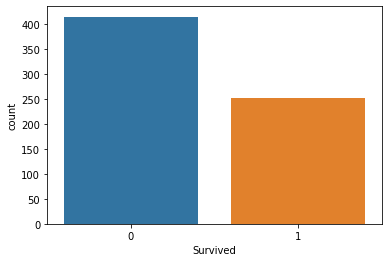

In [101]:
# display that as a graphic.
import seaborn as sns
sns.countplot(y_train);

What if we guessed the majority class for every prediction?

In [102]:
# Remember, "mode" is the most frequent value -- which in this case is "0".
majority_class = y_train.mode()

In [103]:
# create a list of zeroes as long as our training dataset.
y_pred = [majority_class] * len(y_train)

#### Use a classification metric: accuracy

[Classification metrics are different from regression metrics!](https://scikit-learn.org/stable/modules/model_evaluation.html)
- Don't use _regression_ metrics to evaluate _classification_ tasks.
- Don't use _classification_ metrics to evaluate _regression_ tasks.

[Accuracy](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score) is a common metric for classification. Accuracy is the ["proportion of correct classifications"](https://en.wikipedia.org/wiki/Confusion_matrix): the number of correct predictions divided by the total number of predictions.

What is the baseline accuracy if we guessed the majority class for every prediction?

In [104]:
from sklearn.metrics import accuracy_score

In [105]:
# Training accuracy of majority class baseline = 
# frequency of majority class (aka base rate)
accuracy_score(y_train, y_pred)

0.6212574850299402

In [106]:
# Validation accuracy of majority class baseline = 
# usually similar to Train accuracy
y_val = val[target]
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.600896860986547

## Challenge

In your assignment, your Sprint Challenge, and your upcoming Kaggle challenge, you'll begin with the majority class baseline. How quickly can you beat this baseline?

# Express and explain the intuition and interpretation of Logistic Regression


## Overview

To help us get an intuition for *Logistic* Regression, let's start by trying *Linear* Regression instead, and see what happens...

## Follow Along

### Linear Regression?

In [107]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,668.000000,668.000000,668.000000,536.000000,668.000000,668.000000,668.000000
mean,447.450599,0.378743,2.333832,29.421343,0.553892,0.372754,32.179397
std,258.038366,0.485437,0.823707,14.526010,1.185279,0.795588,51.604012
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,221.750000,0.000000,2.000000,20.750000,0.000000,0.000000,7.925000
50%,452.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.400000
75%,673.500000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [108]:
# 1. Import estimator class
from sklearn.linear_model import LinearRegression


In [109]:
# 2. Instantiate this class
linear_reg = LinearRegression()

In [110]:
# 3. Arrange X feature matrices (already did y target vectors)
features = ['Pclass', 'Age', 'Fare']
X_train = train[features]
X_val = val[features]

In [111]:
# do we have any missing values?
X_train.isnull().sum()

Pclass      0
Age       132
Fare        0
dtype: int64

In [112]:
# Impute missing values for Age
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

In [113]:
# 4. Fit the model
linear_reg.fit(X_train_imputed, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [114]:
# 5. Apply the model to new data.
# The predictions look like this ...
linear_reg.predict(X_val_imputed)

array([ 0.23418773,  0.414959  ,  0.29142187,  0.60240298,  0.33464094,
        0.70204713,  0.22782825,  0.32690633,  0.31821017,  0.70458858,
        0.60612454,  0.12990727,  0.2428592 ,  0.22348605,  0.38340904,
        0.73591945,  0.57199051,  0.22789544,  0.44401679,  0.53784936,
        0.26446032,  0.60380195,  0.298096  ,  0.2925248 ,  0.23355499,
        0.37571072,  0.5643901 ,  0.41708001,  0.41611588,  0.21728567,
        0.29813129,  0.27780501,  0.63815283,  0.22765856,  0.30499631,
        0.24982192,  0.65180034,  0.22782825,  0.63451413,  0.22795194,
        0.53575051,  0.23006821,  0.22808277,  0.22782825,  0.12860643,
        0.34079898,  0.298354  ,  0.27232222,  0.26374274,  0.5157593 ,
        0.40205002,  0.53938723,  0.1736849 ,  0.83797194, -0.01176533,
        0.7565994 ,  0.4082248 ,  0.68352778,  0.39693048,  0.29811721,
        0.28456041,  0.54381014,  0.44831187,  0.63410525,  0.22782825,
        0.23986996,  0.53575051,  0.2307717 ,  0.31103413,  0.52

In [115]:
# Get coefficients
pd.Series(linear_reg.coef_, features)

Pclass   -0.195429
Age      -0.006734
Fare      0.000848
dtype: float64

In [116]:
test_case = [[1, 5, 500]]  # 1st class, 5-year old, Rich
linear_reg.predict(test_case)

array([1.20077135])

### Logistic Regression!

In [117]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))

Validation Accuracy 0.7354260089686099


In [118]:
# The predictions look like this
log_reg.predict(X_val_imputed)

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0])

In [119]:
# what about our test case (5-year old boy with $500 ticket)
log_reg.predict(test_case)

array([1])

In [120]:
# probability of death/survival
log_reg.predict_proba(test_case)

array([[0.02418324, 0.97581676]])

In [121]:
# what are the coefficients for our predictors?
print(features)
print(log_reg.coef_)

['Pclass', 'Age', 'Fare']
[[-0.84573613 -0.03196344  0.0049728 ]]


In [122]:
# the intercept: survival when all features are set to zero
log_reg.intercept_

array([2.21676629])

# Use sklearn.linear_model.LogisticRegression to fit and interpret Logistic Regression models

## Overview

Now that we have more intuition and interpretation of Logistic Regression, let's use it within a realistic, complete scikit-learn workflow, with more features and transformations.

## Follow Along

Select these features: `['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']`

(Why shouldn't we include the `Name` or `Ticket` features? What would happen here?) 

Fit this sequence of transformers & estimator:

- [category_encoders.one_hot.OneHotEncoder](https://contrib.scikit-learn.org/categorical-encoding/onehot.html)
- [sklearn.impute.SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
- [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
- [sklearn.linear_model.LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

Get validation accuracy.

In [123]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((668, 7), (668,), (223, 7), (223,))

In [124]:
# any missing data?
print(X_train.isnull().sum())
print(X_val.isnull().sum())

Pclass        0
Sex           0
Age         132
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64
Pclass       0
Sex          0
Age         45
SibSp        0
Parch        0
Fare         0
Embarked     0
dtype: int64


In [125]:
# impute those 2 missing rows of "embarked" with the most frequent value
print(X_train['Embarked'].value_counts())
X_train['Embarked'].fillna('S', inplace=True)
print(X_train.isnull().sum())

S    491
C    117
Q     58
Name: Embarked, dtype: int64
Pclass        0
Sex           0
Age         132
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [126]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [127]:
# take a look at our features
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
298,1,male,NaN,0,0,30.5000,S
884,3,male,25.00,0,0,7.0500,S
247,2,female,24.00,0,2,14.5000,S
478,3,male,22.00,0,0,7.5208,S
305,1,male,0.92,1,2,151.5500,S


In [128]:
# looks like we have some categorical variables in there
X_val.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
709,3,male,NaN,1,1,15.2458,C
439,2,male,31.0,0,0,10.5000,S
840,3,male,20.0,0,0,7.9250,S
720,2,female,6.0,0,1,33.0000,S
39,3,female,14.0,1,0,11.2417,C


In [129]:
# let's convert the categorical variables to dummies using one-hot encoding in our training dataset.
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)

In [130]:
# now we do the same thing for our validation dataset
X_val_encoded = encoder.transform(X_val)

In [131]:
# what do the results look like?
X_train_encoded.head()

,Pclass,Sex_male,Sex_female,Age,SibSp,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q
298,1,1,0,NaN,0,0,30.5000,1,0,0
884,3,1,0,25.00,0,0,7.0500,1,0,0
247,2,0,1,24.00,0,2,14.5000,1,0,0
478,3,1,0,22.00,0,0,7.5208,1,0,0
305,1,1,0,0.92,1,2,151.5500,1,0,0


In [132]:
# we also want to impute missing values for age, as we did before.
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)


In [133]:
# note that, for the validation dataset, we want to use the same mean as the training dataset (so we don't re-fit)
X_val_imputed = imputer.transform(X_val_encoded)

In [134]:
# finally, we want to scale our data so they're all on the same metric.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

In [135]:
# again, for the validation dataset we don't re-fit the scaler. 
X_val_scaled = scaler.transform(X_val_imputed)

In [142]:
# what do our transformed data look like?
pd.DataFrame(X_val_scaled).head()

,0,1,2,3,4,5,6,7,8,9
0,0.809349,0.722247,-0.722247,0.000000,0.376656,0.788996,-0.328391,-1.678435,2.170116,-0.308354
1,-0.405584,0.722247,-0.722247,0.121437,-0.467660,-0.468878,-0.420425,0.595793,-0.460805,-0.308354
2,0.809349,0.722247,-0.722247,-0.724733,-0.467660,-0.468878,-0.470362,0.595793,-0.460805,-0.308354
3,-0.405584,-1.384569,1.384569,-1.801676,-0.467660,0.788996,0.015914,0.595793,-0.460805,-0.308354
4,0.809349,-1.384569,1.384569,-1.186280,0.376656,-0.468878,-0.406042,-1.678435,2.170116,-0.308354


In [144]:
# we're finally ready to fit out model using the transformed training dataset.
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [145]:
# make predictions
y_pred = model.predict(X_val_scaled)

In [146]:
# there are different two ways to output the model's accuracy.
print('Validation Accuracy', accuracy_score(y_val, y_pred))
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.8071748878923767
Validation Accuracy 0.8071748878923767


Plot coefficients:

In [150]:
# what are the coeffs? what do they mean?
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
print(coefficients)

Pclass       -0.796128
Sex_male     -0.637771
Sex_female    0.637771
Age          -0.441080
SibSp        -0.324210
Parch        -0.109567
Fare          0.165687
Embarked_S   -0.094984
Embarked_C    0.093482
Embarked_Q    0.022137
dtype: float64


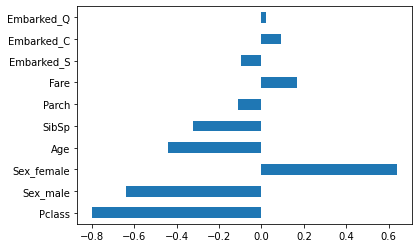

In [148]:
# display the coeffs alphabetically, by name
coefficients.plot.barh();

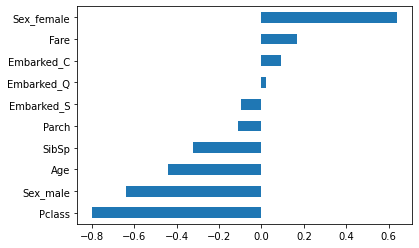

In [147]:

# display the coeffs from least to greatest
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

Generate [Kaggle](https://www.kaggle.com/c/titanic) submission:

In [ ]:
# repeat all the pre-processing steps for the test dataset
X_test = test[features]
X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)

In [ ]:
# the submission should have only 2 columns: the ID, and the prediction, for each passenger.
submission = test[['PassengerId']].copy()
submission['Survived'] = y_pred

In [ ]:
# convert to a csv file for upload to the kaggle website.
submission.to_csv('titanic-submission-01.csv', index=False)

## Challenge

You'll use Logistic Regression for your assignment, your Sprint Challenge, and optionally for your first model in our Kaggle challenge!

# Review

For your assignment, you'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- Begin with baselines for classification.
- Use scikit-learn for logistic regression.
- Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- Get your model's test accuracy. (One time, at the end.)
- Commit your notebook to your fork of the GitHub repo.
- Watch Aaron's [video #1](https://www.youtube.com/watch?v=pREaWFli-5I) (12 minutes) & [video #2](https://www.youtube.com/watch?v=bDQgVt4hFgY) (9 minutes) to learn about the mathematics of Logistic Regression.

# Sources
- Brandon Rohrer, [Training, Validation, and Testing Data Sets](https://end-to-end-machine-learning.teachable.com/blog/146320/training-validation-testing-data-sets)
- Hadley Wickham, [R for Data Science](https://r4ds.had.co.nz/model-intro.html#hypothesis-generation-vs.hypothesis-confirmation), Hypothesis generation vs. hypothesis confirmation
- Hastie, Tibshirani, and Friedman, [The Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/), Chapter 7: Model Assessment and Selection
- Mueller and Guido, [Introduction to Machine Learning with Python](https://books.google.com/books?id=1-4lDQAAQBAJ&pg=PA270), Chapter 5.2.2: The Danger of Overfitting the Parameters and the Validation Set
- Provost and Fawcett, [Data Science for Business](https://books.google.com/books?id=4ZctAAAAQBAJ&pg=PT276), Chapter 7.3: Evaluation, Baseline Performance, and Implications for Investments in Data
- Rachel Thomas, [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)
- Sebastian Raschka, [Model Evaluation](https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html)
- Will Koehrsen, ["A baseline for classification can be the most common class in the training dataset."](https://twitter.com/koehrsen_will/status/1088863527778111488)